In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg
import time

import sys
sys.path.insert(0, '..')
import specsens as ss

Threshold is: 24971.142858522962 with 1024 samples
   infs left at  0.00%
 15.25s left at  1.00%
 15.04s left at  2.00%
 15.40s left at  3.00%
 14.57s left at  4.00%
 16.41s left at  5.00%
 16.78s left at  6.00%
 14.68s left at  7.00%
 14.16s left at  8.00%
 13.97s left at  9.00%
 13.61s left at 10.00%
 13.62s left at 11.00%
 13.34s left at 12.00%
 13.47s left at 13.00%
 13.06s left at 14.00%
 13.33s left at 15.00%
 12.78s left at 16.00%
 12.83s left at 17.00%
 12.39s left at 18.00%
 12.49s left at 19.00%
 12.09s left at 20.00%
 12.38s left at 21.00%
 11.86s left at 22.00%
 11.87s left at 23.00%
 11.50s left at 24.00%
 11.59s left at 25.00%
 11.18s left at 26.00%
 11.28s left at 27.00%
 10.90s left at 28.00%
 10.99s left at 29.00%
 10.62s left at 30.00%
 10.68s left at 31.00%
 10.29s left at 32.00%
 10.28s left at 33.00%
  9.97s left at 34.00%
 10.05s left at 35.00%
  9.70s left at 36.00%
  9.66s left at 37.00%
  9.38s left at 38.00%
  9.37s left at 39.00%
  9.06s left at 40.00%
  9.15

/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars


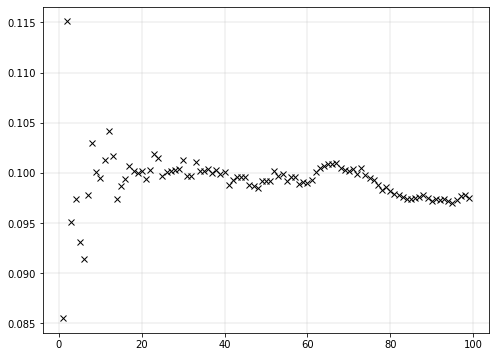

Theory     pfa 0.1
Simulation pfa 0.09737159226209606
Theory     pd  0.4179713989642303
Simulation pd  0.4167498830062879
Threshold      24971.142858522962


In [10]:
class MonteCarloSim():
    def __init__(self, gens, itrs):
        self.gens = gens  # Number of generations
        self.itrs = itrs  # NUmber of iterations per generation
        self.reset()

    def reset(self):
        self.pfas = list()  # Probability of false alarm list
        self.pds = list()  # Probability of detection list
        self.time = None

    def run(self,
            signal_strength=0.,
            noise_strength=0.,
            sample_freq=1e6,
            length=1.,
            pre_pfa=0.1):

        self.reset()

        n_samples = ss.util.get_signal_length(f_sample=sample_freq,
                                              t_sec=length)
        thr = ss.chi2_stats.get_thr(
            noise_power=noise_strength,
            pfa=pre_pfa,
            n=n_samples,
            dB=True)
        print(f'Threshold is: {thr} with {n_samples} samples')

        for i in range(self.gens):

            wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
            wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)

            correct_hit = 0
            false_hit = 0
            correct_miss = 0
            false_miss = 0
            times_signal_present = 0

            # As soon as we introduce noise uncertainty, the detector performs badly
            # This is expected, as energy detectors cant handle noise uncertainty
            # noise_uncertainty = np.random.uniform(-1., 1.)
            noise_uncertainty = 0.

            for j in range(self.itrs):
                
                # Generate signal and noise
                sig = wm.get_soft(f_center=1e5, dB=signal_strength)
                noise = wgn.get_signal(dB=noise_strength + noise_uncertainty)
                
                # Randomly decide whether signal should be present
                sig_present = bool(np.random.randint(2))
                if sig_present:
                    both = sig + noise
                    times_signal_present += 1
                else:
                    both = noise

                # Classic energy detector
                eng = ss.EnergyDetector.get(both)

                # Threshold
                sig_detected = eng > thr
                
                # Log signal and detection outcome
                if sig_present and sig_detected:
                    correct_hit += 1
                elif sig_present and not sig_detected:
                    false_miss += 1
                elif not sig_present and sig_detected:
                    false_hit += 1
                else:
                    correct_miss += 1
            
            # Compute stats and store in list
            pfa_tmp = false_hit / (self.itrs - times_signal_present)
            pd_tmp = correct_hit / times_signal_present
            self.pfas.append(pfa_tmp)
            self.pds.append(pd_tmp)
            
            # Print simulation progress
            rem, per = self.runtime_stats(self.gens, i)
            print('%6.2fs left at %5.2f%%' % (rem, per))
        
        # Compute stats from list 
        pfa = np.sum(self.pfas) / self.gens
        pd = np.sum(self.pds) / self.gens
        return pfa, pd

    def runtime_stats(self, total_itr, current_itr):
        if self.time is None: # First iteration cant predict time
            self.time = time.time()
            return float('inf'), 0.0
        delta_time = time.time() - self.time
        self.time = time.time()
        remaining_itr = total_itr - current_itr
        remaining_time = delta_time * remaining_itr
        percent_done = current_itr / total_itr * 100.0
        return remaining_time, percent_done

    def print_convergence(self):
        plt.figure(figsize=(8, 6))
        plt.grid(linewidth=0.3)
        for i in range(self.gens):
            inter = np.sum(self.pfas[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.show()


signal_strength = -1.
noise_strength = 13.7
pre_pfa = 0.1
length = 0.001024
sample_freq = 1e6
sim = MonteCarloSim(100, 300)
pfa, pd = sim.run(signal_strength=signal_strength,
                  noise_strength=noise_strength,
                  sample_freq=sample_freq,
                  length=length,
                  pre_pfa=pre_pfa)

sim.print_convergence()

print(f'Theory     pfa {pre_pfa}')
print(f'Simulation pfa {pfa}')

n_samples = ss.util.get_signal_length(f_sample=sample_freq, t_sec=length)
thr = ss.chi2_stats.get_thr(
    noise_power=noise_strength,
    pfa=pre_pfa,
    n=n_samples,
    dB=True)
print(f'Theory     pd  {ss.chi2_stats.get_pd(noise_strength, signal_strength, thr, n_samples, dB=True)}')
print(f'Simulation pd  {pd}')
print(f'Threshold      {thr}')

In [3]:
print(f'--CLT--')
print(f'Threshold      {ss.clt_stats.get_thr(noise_fac, pre_pfa, n_samples)}')
print(f'Theory     pfa {ss.clt_stats.get_pfa(noise_fac, thr, n_samples)}')
print(f'Theory     pd  {ss.clt_stats.get_pd(noise_fac, signal_fac, thr, n_samples)}')
print(f'Theory     n   {ss.clt_stats.get_num(noise_power=noise_fac, signal_power=signal_fac, pfa=pre_pfa, pd=0.2044)}')

--CLT--


NameError: name 'noise_fac' is not defined